In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [10]:
# --- Data Preparation ---

df = pd.read_csv('../data/course_lead_scoring.csv')

In [11]:
# Identify feature types
categorical_cols = ['lead_source', 'industry', 'employment_status', 'location']
numerical_cols = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

In [12]:
# 2. Handle missing values
# 2.1 For categorical features, replace with 'NA'
df[categorical_cols] = df[categorical_cols].fillna('NA')
# 2.2 For numerical features, replace with 0.0
df[numerical_cols] = df[numerical_cols].fillna(0.0)

In [13]:
# Split the data into 3 parts: train/validation/test (60%/20%/20%)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1) # 0.25 * 0.8 = 0.2

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

In [14]:
# Separate target variable (y)
y_train = df_train.converted.values
y_val = df_val.converted.values
y_full_train = df_full_train.converted.values

In [15]:
# Drop the target variable from features dataframes
del df_train['converted']
del df_val['converted']
del df_full_train['converted']

In [16]:
# --- Question 1: ROC AUC feature importance ---
q1_numerical_features = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
auc_scores = {}

for col in q1_numerical_features:
    y_pred = df_train[col].values
    auc = roc_auc_score(y_train, y_pred)
    # Check for inversion
    if auc < 0.5:
        auc = roc_auc_score(y_train, -y_pred)
    auc_scores[col] = auc

In [17]:
# --- DictVectorizer Preparation for Questions 2-6 ---
all_features = df.columns.drop('converted').tolist()
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
categorical = [col for col in all_features if col not in numerical]

def prepare_dictionaries(df):
    return df[categorical + numerical].to_dict(orient='records')

train_dicts = prepare_dictionaries(df_train)
val_dicts = prepare_dictionaries(df_val)
full_train_dicts = prepare_dictionaries(df_full_train)

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)
X_full_train = dv.transform(full_train_dicts)

In [18]:
# --- Question 2: Training the model and Validation AUC ---
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_train, y_train)
y_pred_val = model.predict_proba(X_val)[:, 1]
q2_auc = roc_auc_score(y_val, y_pred_val)

In [19]:
# --- Question 3 & 4: Precision, Recall, and F1 Score vs. Threshold ---
thresholds = np.linspace(0.0, 1.0, 101)
scores = []

for t in thresholds:
    y_pred_binary = (y_pred_val >= t).astype(int)
    TP = ((y_pred_binary == 1) & (y_val == 1)).sum()
    FP = ((y_pred_binary == 1) & (y_val == 0)).sum()
    FN = ((y_pred_binary == 0) & (y_val == 1)).sum()

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    scores.append((t, precision, recall, f1))

df_scores = pd.DataFrame(scores, columns=['threshold', 'precision', 'recall', 'f1'])

In [20]:
# Q3: Intersection Threshold (where precision and recall are closest)
df_q3_valid = df_scores[df_scores['recall'] > 0]
df_q3_intersect = df_q3_valid.iloc[(df_q3_valid['precision'] - df_q3_valid['recall']).abs().argsort()[:1]]
q3_intersection_threshold = df_q3_intersect['threshold'].values[0]

In [21]:
# Q4: Maximal F1 score threshold
df_q4_max_f1 = df_scores.sort_values(by='f1', ascending=False).iloc[0]
q4_max_f1_threshold = df_q4_max_f1['threshold']

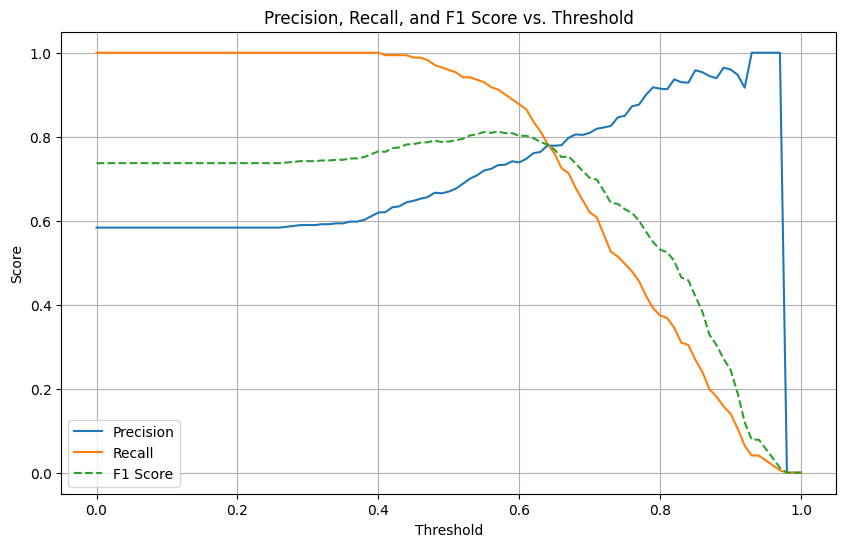

In [22]:
# Plotting for Q3/Q4
plt.figure(figsize=(10, 6))
plt.plot(df_scores.threshold, df_scores.precision, label='Precision')
plt.plot(df_scores.threshold, df_scores.recall, label='Recall')
plt.plot(df_scores.threshold, df_scores.f1, label='F1 Score', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.savefig('precision_recall_f1_vs_threshold.png')

In [23]:
# --- Question 5: 5-Fold CV Standard Deviation ---
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
q5_scores = []
for train_idx, val_idx in kfold.split(X_full_train):
    X_train_fold, X_val_fold = X_full_train[train_idx], X_full_train[val_idx]
    y_train_fold, y_val_fold = y_full_train[train_idx], y_full_train[val_idx]

    model_cv = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
    model_cv.fit(X_train_fold, y_train_fold)
    y_pred_val_cv = model_cv.predict_proba(X_val_fold)[:, 1]
    q5_scores.append(roc_auc_score(y_val_fold, y_pred_val_cv))

q5_std = np.std(q5_scores)

In [24]:
# --- Question 6: Hyperparameter Tuning ---
C_values = [0.000001, 0.001, 1]
q6_results = []
for C in C_values:
    C_scores = []
    for train_idx, val_idx in kfold.split(X_full_train):
        X_train_fold, X_val_fold = X_full_train[train_idx], X_full_train[val_idx]
        y_train_fold, y_val_fold = y_full_train[train_idx], y_full_train[val_idx]

        model_cv = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=1)
        model_cv.fit(X_train_fold, y_train_fold)
        y_pred_val_cv = model_cv.predict_proba(X_val_fold)[:, 1]
        C_scores.append(roc_auc_score(y_val_fold, y_pred_val_cv))

    mean_score = np.mean(C_scores)
    std_score = np.std(C_scores)
    q6_results.append({'C': C, 'mean_auc': mean_score, 'std_auc': std_score})

df_q6_results = pd.DataFrame(q6_results)
# Find the best C based on sorting criteria
df_q6_best = df_q6_results.sort_values(by=['mean_auc', 'std_auc', 'C'], ascending=[False, True, True]).iloc[0]

In [25]:
# --- Print Final Answers ---
print(f"Q1 - Highest AUC variable: {max(auc_scores, key=auc_scores.get)} (AUC: {max(auc_scores.values()):.4f})")
print(f"Q2 - Validation AUC: {q2_auc:.3f}")
print(f"Q3 - Intersection Threshold: {q3_intersection_threshold:.3f}")
print(f"Q4 - Maximal F1 Threshold: {q4_max_f1_threshold:.2f}")
print(f"Q5 - CV Standard Deviation: {q5_std:.4f}")
print(f"Q6 - Best C: {df_q6_best['C']} (Mean AUC: {df_q6_best['mean_auc']:.3f}, Std AUC: {df_q6_best['std_auc']:.3f})")

Q1 - Highest AUC variable: number_of_courses_viewed (AUC: 0.7636)
Q2 - Validation AUC: 0.817
Q3 - Intersection Threshold: 0.640
Q4 - Maximal F1 Threshold: 0.57
Q5 - CV Standard Deviation: 0.0358
Q6 - Best C: 0.001 (Mean AUC: 0.867, Std AUC: 0.029)


new one